In [70]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from sklearn import svm, metrics, model_selection, linear_model
from datetime import date


# Extraction of the data

In [2]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
daily='csse_covid_19_daily_reports/' #+date in the form  01-22-2020.csv
time_serie='csse_covid_19_time_series/' #+confirmed, death,recovered
confirmed_data='time_series_covid19_confirmed_global.csv'
death_data='time_series_covid19_deaths_global.csv'
recovered_data='time_series_covid19_recovered_global.csv'

In [3]:
confirmed=pd.read_csv(url+time_serie+confirmed_data)
dead=pd.read_csv(url+time_serie+death_data)
recovered=pd.read_csv(url+time_serie+recovered_data)

In [101]:
def make_date(day,month):   #convert a date in (day,month) format to a string to feed in the read_csv function
    day=str(day)
    month=str(month)
    if len(day)==1:
        day='0'+day
    if len(month)==1:
        month='0'+month 
    date=month+'-'+day+'-2020'
    return date
today = str(date.today())
today=make_date(int(today[5])+int(today[6]),int(today[8])+int(today[9]))


In [91]:
#This cell save the data for the us in a dictionary us_data. Pay attention to adjuste to if statement to
#adjust it at the current date. The value of the dict are dataframe with: first ligne:confirme case, second: dead, 
#third: recovered. the columns are the different dates
us_data={}
total_state=[]
for month in range(1,4):
    for day in range(1,32):
        if month==1 and day<23:
            pass
        elif month==2 and day>29:
            pass
        elif month==4:
            pass
        else:
            dat=make_date(day,month)
            #print(dat)
            today=pd.read_csv(url+daily+dat+'.csv')
            if month<3 or (month==3 and day<22):
                st='Province/State'
                country='Country/Region'
            else:
                st='Province_State'
                country='Country_Region'
            for i, state in enumerate(today[st]):
                if today[country].iloc[i]!='US':
                    pass
                else:
                    if state not in total_state:
                        total_state.append(state)
                        us_data[state]=pd.DataFrame()
                        us_data[state][dat]=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                    elif dat not in us_data[state].columns:
                        us_data[state][dat]=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                    else:
                        us_data[state][dat]+=np.array([today['Confirmed'].iloc[i],today['Deaths'].iloc[i],today['Recovered'].iloc[i]])
                        
                    
  

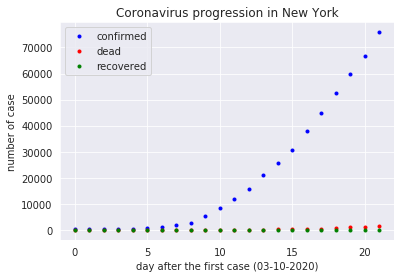

In [7]:
# coronavirus progression plot for any state in the us: just pick one
state='New York'
time=np.arange(len(us_data[state].iloc[0,:]))
plt.figure()
plt.title('Coronavirus progression in '+state)
plt.xlabel('day after the first case ('+us_data[state].columns[0]+')')
plt.ylabel('number of case')
plt.plot(time,us_data[state].iloc[0,:],'b.',label='confirmed')
plt.plot(time,us_data[state].iloc[1,:],'r.',label='dead')
plt.plot(time,us_data[state].iloc[2,:],'g.',label='recovered')
plt.legend()
#plt.xlim()
plt.show()

# Data Exploration

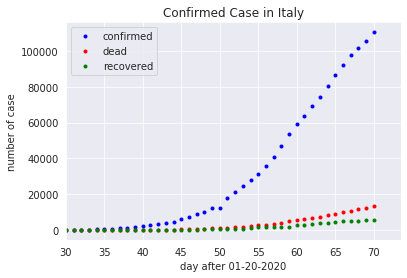

In [8]:
confirmed_italy=confirmed.iloc[137,4:]
dead_italy=dead.iloc[137,4:]
recovered_italy=recovered.iloc[137,4:]
confirmed_italy
time=np.arange(len(confirmed_italy))
plt.figure()
plt.title('Confirmed Case in Italy')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_italy,'b.',label='confirmed')
plt.plot(time,dead_italy,'r.',label='dead')
plt.plot(time,recovered_italy,'g.',label='recovered')
plt.legend()
plt.xlim(30)
plt.show()

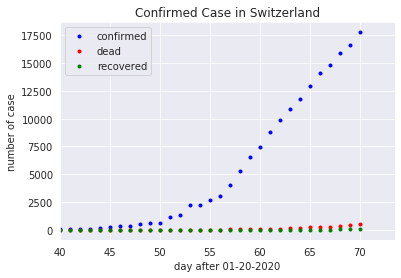

In [9]:
confirmed_swiss=confirmed.iloc[206,4:]
dead_swiss=dead.iloc[206,4:]
recovered_swiss=recovered.iloc[206,4:]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b.',label='confirmed')
plt.plot(time,dead_swiss,'r.',label='dead')
plt.plot(time,recovered_swiss,'g.',label='recovered')
plt.legend()
plt.xlim(40)
plt.show()

Contaminated Prediction for the next day in Switzerland

Method: using previous day to predict next: using the model on the last data point to predict tomorrow

In [110]:
for i,s in enumerate(confirmed_swiss):
    if s==0:
        pass
    if s!=0:
        start=i
        break
#modelling for the swiss case
N=8.57*10**6
#start parameter
beta=1
gamma=1
S=[] #possible 
I=[] #infected
R=[] #removed (dead+cured)
for i in range (len(confirmed_swiss)):
    if i<start:
        pass
    else:
        I.append(confirmed_swiss[i])
        R.append(recovered_swiss[i]+dead_swiss[start])
        S.append(N-I[-1]-R[-1])
model=linear_model.Ridge()
X=pd.DataFrame()
X['St']=np.array(S[1:-2])
X['It']=np.array(I[1:-2])
X['Rt']=np.array(R[1:-2])
X['SI']=X['St']*X['It']
X_last_day=pd.DataFrame()
X_last_day['S']=np.array(S[-1:])
X_last_day['I']=np.array(I[-1:])
X_last_day['R']=np.array(R[-1:])
X_last_day['SI']=X_last_day['S']*X_last_day['I']
y=pd.DataFrame()
prediction_next_day=pd.DataFrame()
prediction_next_day[today]=np.array([0,0,0])
y['St+1']=np.array(S[2:-1])
y['It+1']=np.array(I[2:-1])
y['Rt+1']=np.array(R[2:-1])

for i, col in enumerate(y.columns):
    model.fit(X,y[col])
    prediction_next_day[today].iloc[i]=model.predict((X_last_day))
print('prediction: ',prediction_next_day)
prediction_next_day.to_csv('prediction_nextday_swiss.csv')

prediction:       02-04-2020
0  8.551750e+06
1  1.820841e+04
2  4.173201e+01


/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.54882e-23): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.54882e-23): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.54882e-23): result may not be accurate.
  overwrite_a=True).T


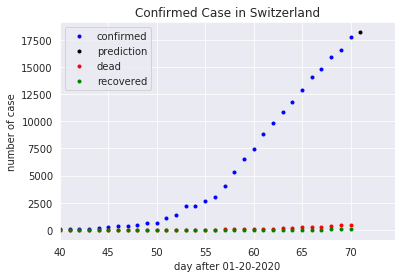

In [111]:
confirmed_swiss=confirmed.iloc[206,4:]
dead_swiss=dead.iloc[206,4:]
recovered_swiss=recovered.iloc[206,4:]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
new_time=np.arange(time[-1]+1,time[-1]+1+len(prediction_next_day.columns))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b.',label='confirmed')
plt.plot(new_time,prediction_next_day.iloc[1],'k.',label='prediction')
plt.plot(time,dead_swiss,'r.',label='dead')
plt.plot(time,recovered_swiss,'g.',label='recovered')
plt.legend()
plt.xlim(40)
plt.show()